In [31]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df=pd.read_csv('newdataset1.csv')

In [33]:
df.head(6)

,Age,Overall,Potential,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,...,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,Preferred Positions
0,32,94,94,95500000,565000,2228,89,63,89,63,...,53,82,62,91,89,92,91,66,92,ST
1,30,93,93,105000000,565000,2154,92,48,90,95,...,45,84,59,92,90,88,91,62,88,RW
2,25,92,94,123000000,280000,2100,94,56,96,82,...,46,79,59,88,87,84,89,64,84,LW
3,30,92,92,97000000,510000,2291,88,78,86,60,...,58,80,65,88,85,88,87,68,88,ST
4,28,91,91,92000000,355000,2143,79,80,78,80,...,57,78,62,87,82,88,84,61,88,ST
5,26,90,91,90500000,295000,2096,93,54,93,91,...,47,81,61,87,87,82,88,64,82,LW


In [34]:
xnames = np.asarray(df.columns.tolist())[:35]
xnames = np.delete(xnames,[1,2,3,4])

In [35]:
xnames.shape

(31,)

In [36]:
#y=df['Wage'].as_matrix()
y=df['Overall'].as_matrix()
dummy = df[xnames].as_matrix()
position = df['Preferred Positions'].as_matrix()
position_unique,position = np.unique(position, return_inverse=True)

In [37]:
x = np.ndarray((len(y),32))
x[:,:31]=dummy
x[:,31] = position

In [38]:
from sklearn import linear_model, preprocessing
x = preprocessing.scale(x)
y = preprocessing.scale(y)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [39]:
# X=x[:6000,:]
# Y=y[:6000]
X=x
Y=y

In [40]:
import  sklearn.model_selection
from sklearn import linear_model

In [41]:
X.shape

(15143, 32)

In [42]:
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-2,1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = Y[Itr]
    X_ts = X[Its,:]
    y_ts = Y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model.alpha = a
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

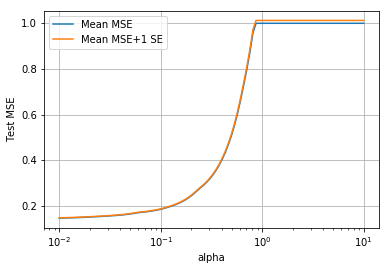

In [43]:
mse_mean = np.mean(mse,axis=1)
mse_std = np.std(mse,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_mean)
plt.semilogx(alphas, mse_mean+mse_std)
plt.legend(['Mean MSE', 'Mean MSE+1 SE'],loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

Optimal alpha = 0.013219


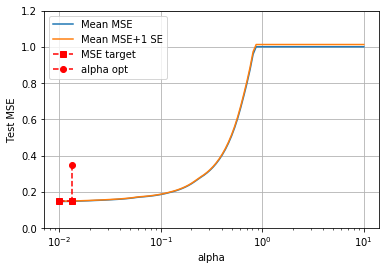

In [44]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_mean)
plt.semilogx(alphas, mse_mean+mse_std)

# Plot the MSE target
plt.semilogx([alpha_min,alpha_opt], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.semilogx([alpha_opt,alpha_opt], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['Mean MSE', 'Mean MSE+1 SE', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.ylim([0,1.2])
plt.grid()
plt.show()

In [60]:
np.append(xnames,'Preferred Positions')
model.alpha = alpha_opt
#print(alpha_opt)
model.fit(X,Y)

new = []

for i in range(len(model.coef_)-1):
    if model.coef_[i]>0:
        print("%s\t %f" % (xnames[i], model.coef_[i]))
        new.append(xnames[i])
# for i in range(len(model.coef_)-1):
#     print("%8s %f" % (xnames[i], model.coef_[i]))

Age	 0.024862
Special	 0.052864
Acceleration	 0.043361
Ball control	 0.230498
Composure	 0.193394
Crossing	 0.000439
Heading accuracy	 0.166758
Interceptions	 0.007984
Marking	 0.000840
Reactions	 0.336106
Short passing	 0.094473
Sprint speed	 0.062678
Stamina	 0.002652
Standing tackle	 0.051042
Strength	 0.084753


In [46]:
# y_pre=model.predict(X)
# RSS=np.mean((y_pre-Y)**2)/(np.std(Y)**2)
# Rsq=1-RSS
# print("Rss per sample={0:f}".format(RSS))
# print("R^2=           {0:f}".format(Rsq))

In [47]:
new = np.asarray(new)

In [48]:
X_new = df[new].as_matrix()
#Y_new = df['Wage'].as_matrix()
Y_new = df['Overall'].as_matrix()
X_new = preprocessing.scale(X_new)
Y_new = preprocessing.scale(Y_new)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [49]:
X_new.shape

(15143, 15)

In [50]:
model_new = linear_model.Lasso(warm_start=True)
model_new.alpha = alpha_opt
model_new.fit(X_new,Y_new)

Lasso(alpha=0.013219411484660288, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=True)

In [51]:
print(model_new.alpha)

0.0132194114847


In [52]:
y_pred=model_new.predict(X_new)
RSS=np.mean((y_pred-Y_new)**2)/(np.std(Y_new)**2)
Rsq=1-RSS
print("Rss per sample={0:f}".format(RSS))
print("R^2=           {0:f}".format(Rsq))

Rss per sample=0.149215
R^2=           0.850785
